<a href="https://colab.research.google.com/github/jeonghojo00/SpeechRecognition/blob/main/SpeechRecognition_TESS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Select Runtime Type

## GPU

In [1]:
# Run only when Using GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat May 14 19:48:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


# Speech sentiment analysis

## 0. Setup

In [3]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Change directory to the package folder
%cd '/content/drive/MyDrive/Colab Notebooks/DB/TESS'
# Verify the contents of the current folder
!ls

/content/drive/MyDrive/Colab Notebooks/DB/TESS
 model	  TESS					    TESS.zip   X_mfcc.csv
 result  'tess toronto emotional speech set data'   X.csv


In [5]:
# General
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import time
import copy
import pickle
import glob
import seaborn as sns

# Audio Processing
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

# Pytorch libraries for models and input
import torch
import torchvision 
from torchvision import models
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
from torchvision.transforms import transforms, ToTensor

In [6]:
# Execute only when only zip files are present
'''
from zipfile import ZipFile

with ZipFile('./TESS.zip', 'r') as zip:
    #zip.printdir()
    zip.extractall()
    print("TESS Zip Extract Done")
'''

'\nfrom zipfile import ZipFile\n\nwith ZipFile(\'./TESS.zip\', \'r\') as zip:\n    #zip.printdir()\n    zip.extractall()\n    print("TESS Zip Extract Done")\n'

## 1. Data Preparation

### Data Loading

In [7]:
# Load the dataset (2800 datapoints total)
TESS_path = './TESS'
paths = glob.glob(os.path.join(TESS_path,'**/*.wav'), recursive = True)
print(f'{len(paths)} paths are added')

2800 paths are added


In [8]:
labels = []
for filename in paths:
    label = filename.split('_')[-1]
    label = label.split('.')[0]
    labels.append(label.lower())    
print(f'{len(labels)} labels are added')

2800 labels are added


In [9]:
# Create a dataframe
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,./TESS/OAF_Fear/OAF_back_fear.wav,fear
1,./TESS/OAF_Fear/OAF_bar_fear.wav,fear
2,./TESS/OAF_Fear/OAF_base_fear.wav,fear
3,./TESS/OAF_Fear/OAF_bath_fear.wav,fear
4,./TESS/OAF_Fear/OAF_bean_fear.wav,fear


In [10]:
print(df['label'].value_counts())
print("")
print(df['label'].describe())

fear       400
ps         400
sad        400
angry      400
disgust    400
happy      400
neutral    400
Name: label, dtype: int64

count     2800
unique       7
top       fear
freq       400
Name: label, dtype: object


### Exploratory Data Analysis

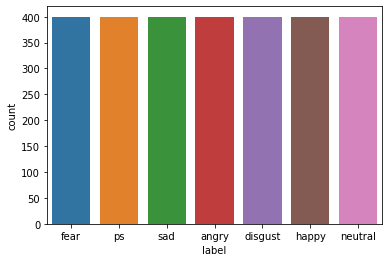

In [11]:
sns.countplot(df['label'])

In [12]:
from locale import D_FMT
def waveplot(data, sr, emotion):
    '''
    This function displays a wave form of an audio file
    sr = sample rate
    '''
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveplot(data, sr = sr)
    plt.show()

def spectogram(data, sr, emotion):
    '''
    This function displays a spectogram of an audio file
    sr = sample rate
    '''
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(x) # x into decibel
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr = sr, x_axis='time', y_axis='hz')
    plt.colorbar()

./TESS/OAF_Fear/OAF_back_fear.wav


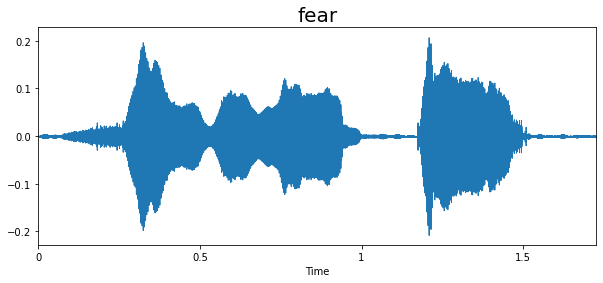

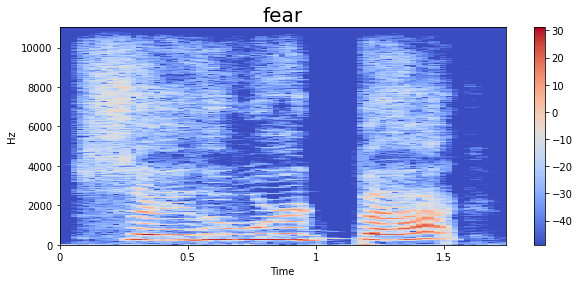

In [13]:
emotion = 'fear'
path = np.array(df['speech'][df['label']==emotion])[0]
print(path)

data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)

Audio(path)

./TESS/OAF_angry/OAF_back_angry.wav


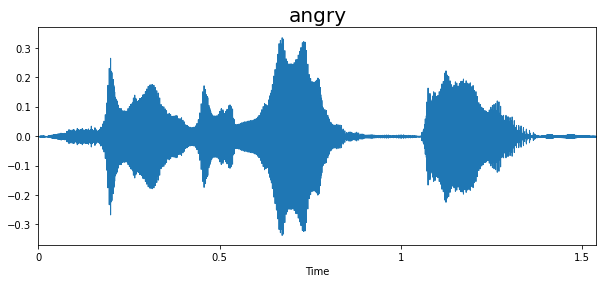

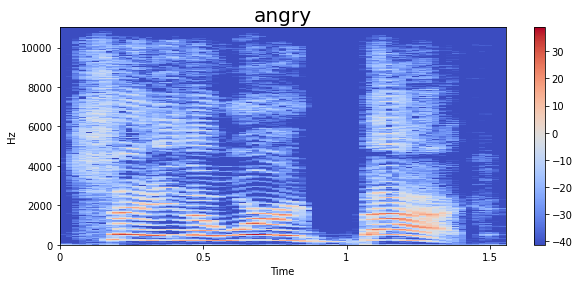

In [14]:
emotion = 'angry'
path = np.array(df['speech'][df['label']==emotion])[0]
print(path)

data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)

Audio(path)

./TESS/OAF_happy/OAF_back_happy.wav


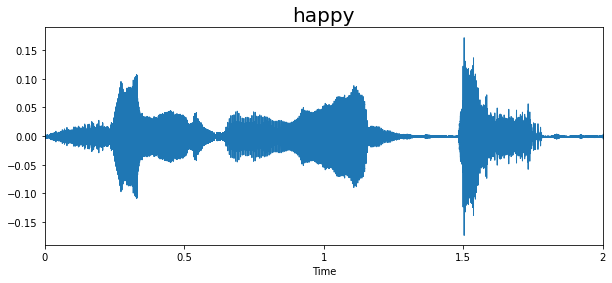

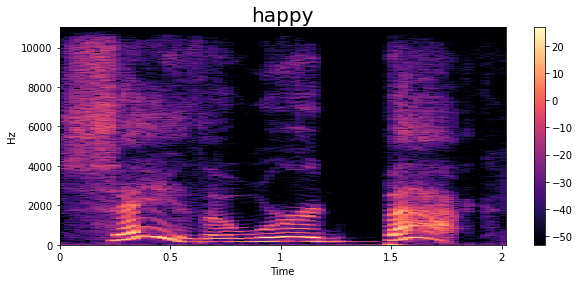

In [15]:
emotion = 'happy'
path = np.array(df['speech'][df['label']==emotion])[0]
print(path)

data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)

Audio(path)

./TESS/OAF_neutral/OAF_back_neutral.wav


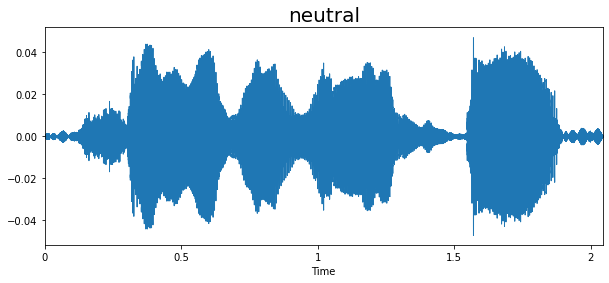

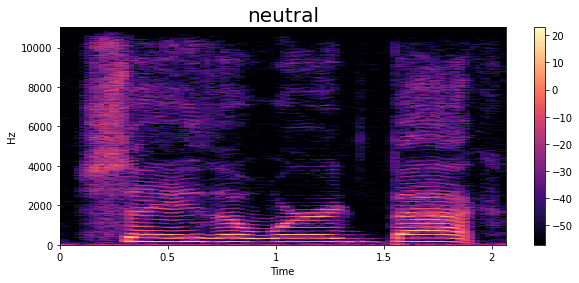

In [16]:
emotion = 'neutral'
path = np.array(df['speech'][df['label']==emotion])[0]
print(path)

data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)

Audio(path)

## 2. Feature Extraction

### Extract mfcc feature for X (Do only once or when data is changed)

In [ ]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration = 3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [ ]:
extract_mfcc(df['speech'][0])

array([-4.4749503e+02,  9.1554199e+01, -3.9023086e-01, -1.7291504e+01,
        2.7826221e+00,  4.7178407e+00, -1.3548041e+01,  5.5741870e-01,
       -1.0805155e+01,  3.2483773e+00, -1.2746214e+01, -6.6335969e+00,
       -6.7705779e+00, -2.3902597e+00, -2.9169650e+00,  2.4589036e+00,
       -7.8448520e+00,  2.7039781e+00,  3.2153213e+00, -7.2382531e+00,
        5.6720991e+00,  1.8850632e+01,  1.4558589e+01,  2.9805136e+01,
        2.1194981e+01,  1.8110538e+01,  7.4543090e+00,  3.3440521e+00,
       -2.7450316e+00,  6.3023963e+00,  5.3630486e-02,  2.4252005e+00,
       -2.8612256e+00, -4.4852743e+00,  6.1673021e-01,  3.2275510e+00,
       -3.1178606e+00, -1.2512102e+00, -2.2621226e+00,  2.0872290e+00],
      dtype=float32)

In [ ]:
X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))

In [ ]:
print(X_mfcc.head())
print("")
print("Shape of X_mfcc: ", X_mfcc.shape)

In [ ]:
# Convert into Numpy array
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(2800, 40)

In [ ]:
# Save in to csv file for the further Use
np.savetxt('X.csv', X, delimiter=',')

### load preprocessed mfcc feature for X

In [17]:
# Load X file saved in csv format
loaded_X = np.loadtxt('X.csv', delimiter=',')
print(loaded_X.shape)
print(loaded_X)
X = loaded_X
#X = torch.from_numpy(X).float() 

(2800, 40)
[[-4.47495026e+02  9.15541992e+01 -3.90230864e-01 ... -1.25121021e+00
  -2.26212263e+00  2.08722901e+00]
 [-4.55846069e+02  9.62042313e+01  1.74650860e+01 ... -1.68521643e+00
  -2.67975378e+00  2.77891588e+00]
 [-4.63173584e+02  5.68415031e+01  1.38546429e+01 ... -1.91643417e+00
  -6.26090193e+00  3.30285215e+00]
 ...
 [-3.79244080e+02  8.07376785e+01  3.58427391e+01 ...  6.60885096e+00
   4.38175154e+00  6.65192747e+00]
 [-4.34532623e+02  9.05700684e+01  2.78381138e+01 ...  1.05432739e+01
   1.16703444e+01  1.00189676e+01]
 [-4.22228394e+02  7.14898453e+01  3.19283638e+01 ...  5.34566307e+00
   4.95724916e+00  6.39294147e+00]]


### One hot coding for y

In [18]:
from sklearn.preprocessing import OneHotEncoder
print("Before One Hot Encoding: ", df[['label']].shape)
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])
y = y.toarray() # Change y data type into numpy array
print("After One Hot Encoding: ", y.shape)

Before One Hot Encoding:  (2800, 1)
After One Hot Encoding:  (2800, 7)


## 3. Experiment

### Data prepartion for training

In [19]:
from sklearn.model_selection import train_test_split
from torch.autograd import Variable 

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=40, shuffle=True)
NUM_TRAIN = len(X_train)
NUM_VAL = len(X_val)

X_train_tensors = Variable(torch.Tensor(X_train))
X_val_tensors = Variable(torch.Tensor(X_val))
y_train_tensors = Variable(torch.Tensor(y_train))
y_val_tensors = Variable(torch.Tensor(y_val)) 

#reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_val_tensors_final = torch.reshape(X_val_tensors,   (X_val_tensors.shape[0], 1, X_val_tensors.shape[1]))

In [20]:
train_data = []
for i in range(len(X_train_tensors_final)):
   train_data.append([X_train_tensors_final[i], y_train_tensors[i]])

val_data = []
for i in range(len(X_val)):
   val_data.append([X_val_tensors_final[i], y_val_tensors[i]])

BATCH_SIZE = 128

train_dl = DataLoader(train_data, batch_size = BATCH_SIZE)
print("{} batches with {} batch size in train_dl".format(len(train_dl), BATCH_SIZE))
val_dl = DataLoader(val_data, batch_size = BATCH_SIZE)
print("{} batches with {} batch size in val_dl".format(len(val_dl), BATCH_SIZE))

18 batches with 128 batch size in train_dl
5 batches with 128 batch size in val_dl


### Define a Model

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class speechRecognition(nn.Module):
    hyper_parameters = {
        "num_classes": 7,
        "n_feats": 40,
        "dropout": 0.1,
        "hidden_size": 128,
        "num_layers": 1
    }
    def __init__(self, hidden_size, num_classes, n_feats, num_layers, dropout):
        super(speechRecognition, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size = n_feats, hidden_size = hidden_size,
                            num_layers = num_layers, dropout=0.0, 
                            bidirectional=False)
        
        self.dense = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.LayerNorm(64),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.LayerNorm(32),
            nn.GELU(),
            nn.Dropout(dropout)
        )
    
        self.final_fc = nn.Linear(32, num_classes)

    def forward(self, x, hs=None):
        # Propagate input through LSTM
        out, hs = self.lstm(x, hs) #lstm with input, hidden, and internal state
        out = out.reshape(-1, self.hidden_size)
        out = self.dense(out)
        out = self.final_fc(out)

        return out

In [22]:
h_params = speechRecognition.hyper_parameters
print("Hyper parameters for Speech recognition model")
print(h_params)
print("")
# Load a model
model = speechRecognition(**h_params).to(DEVICE)
model.train()

Hyper parameters for Speech recognition model
{'num_classes': 7, 'n_feats': 40, 'dropout': 0.1, 'hidden_size': 128, 'num_layers': 1}



speechRecognition(
  (lstm): LSTM(40, 128)
  (dense): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): GELU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (6): GELU()
    (7): Dropout(p=0.1, inplace=False)
  )
  (final_fc): Linear(in_features=32, out_features=7, bias=True)
)

In [ ]:
# Define an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Scheduler: Update learning rate: Every 5 epochs update Learning rate by multiply by 0.1
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Define a loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
x_val,  y_val = next(iter(train_dl))
print(x_val.shape)
print(y_val.shape)

torch.Size([128, 1, 40])
torch.Size([128, 7])


In [ ]:
epoch_loss = 0
epoch_acc = 0

a_audio,  a_label = next(iter(train_dl))
a_audio = a_audio.to(DEVICE)
a_label = a_label.to(DEVICE)


output = model(a_audio)
print("Output in shape: ", output.shape)
print("Output")
print(output.argmax(dim=1))
print("Correct Label in shape: ", a_label.shape)
print(a_label.argmax(dim=1))

loss = criterion(output, a_label)
print("Loss: ", loss.item())

acc = (output.argmax(dim=1) == a_label.argmax(dim=1)).sum().item()
print("Correctness: ", acc, ", Accuracy: ", acc/len(a_audio))

epoch_loss = loss.item()
epoch_acc = acc

optimizer.zero_grad()
loss.backward()
optimizer.step()

print('Epoch : {}, train accuracy : {}, train loss : {}'.format(1, epoch_acc, epoch_loss))

Output in shape:  torch.Size([128, 7])
Output
tensor([1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 6, 2, 1, 1, 1, 1,
        1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1,
        2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 6, 1, 1, 1,
        2, 2, 1, 2, 1, 6, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2,
        1, 1, 1, 2, 2, 1, 6, 2, 1, 2, 1, 6, 2, 1, 6, 6, 2, 1, 2, 1, 1, 1, 2, 1,
        6, 2, 1, 2, 1, 2, 1, 1], device='cuda:0')
Correct Label in shape:  torch.Size([128, 7])
tensor([3, 5, 3, 3, 4, 4, 2, 5, 3, 2, 2, 0, 5, 3, 5, 3, 6, 3, 1, 2, 3, 3, 1, 6,
        1, 2, 6, 2, 1, 0, 4, 3, 2, 2, 1, 5, 0, 5, 3, 3, 1, 1, 4, 4, 6, 6, 3, 1,
        5, 2, 3, 5, 5, 1, 4, 2, 3, 1, 4, 0, 4, 0, 2, 0, 2, 6, 2, 5, 3, 6, 1, 0,
        0, 0, 5, 6, 0, 0, 3, 3, 0, 2, 3, 2, 1, 6, 1, 1, 2, 5, 6, 5, 4, 4, 1, 3,
        5, 5, 1, 0, 2, 4, 1, 3, 0, 2, 5, 0, 1, 6, 5, 5, 3, 2, 3, 4, 3, 6, 3, 1,
        3, 1, 2, 6, 0, 2, 5, 1], device='cuda:0')
Loss:  1

### Define a function for an experiment

In [26]:
def train_and_validate(model, model_path, res_path, criterion, optimizer, scheduler, num_epochs=1):
    print("Training...")
    since = time.time()

    best_model_state = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    record_acc = dict()
    record_loss = dict()
    record_acc['train'] = []
    record_acc['val'] = []
    record_loss['train'] = []
    record_loss['val'] = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        epoch_loss = 0.0
        epoch_acc = 0.0
        epoch_correct = 0
        
        for idx, (speech, label) in enumerate(train_dl):
            speech = speech.to(DEVICE)
            label = label.to(DEVICE)
            
            # Forward
            output = model(speech)
            loss = criterion(output, label)
            acc = (output.argmax(dim=1) == label.argmax(dim=1)).sum().item()
            
            # Backward
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient Descent or Adam step
            optimizer.step()
            
            epoch_loss += (loss.item()/NUM_TRAIN)
            epoch_acc += (acc/NUM_TRAIN)
            
        print(f'Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
        
        record_acc['train'].append(epoch_acc)
        record_loss['train'].append(epoch_loss)

        #res[epoch+1] = {"Train_Loss": epoch_loss, 
        #                "Train_Acc": epoch_acc}
        scheduler.step()

        with torch.no_grad():
            epoch_val_acc = 0.0
            epoch_val_loss = 0.0
            epoch_val_correct = 0
            
            for speech, label in val_dl:
                speech = speech.to(DEVICE)
                label = label.to(DEVICE)
                
                val_output = model(speech)
                val_loss = criterion(val_output, label)
                val_acc = (val_output.argmax(dim=1) == label.argmax(dim=1)).sum().item()
                
                epoch_val_acc += (val_acc/NUM_VAL)
                epoch_val_loss += (val_loss.item()/NUM_VAL)
                
            print(f'Validation Loss: {epoch_val_loss:.4f}, Accuracy: {epoch_val_acc:.4f}')
            record_acc['val'].append(epoch_val_acc)
            record_loss['val'].append(epoch_val_loss)
            #res[epoch+1] = {"Val_Loss": epoch_val_loss, 
            #                "Val_Acc": epoch_val_acc}
        
            if epoch_val_acc > best_acc:
                best_acc = epoch_val_acc
                best_model_state = copy.deepcopy(model.state_dict())
                if not os.path.isdir("model"):
                    os.mkdir("model")
                torch.save(model.state_dict(), model_path)
                print("Model Saved")
    
    # When Training is completed
    time_elapsed = time.time() - since
    print(f'Train completed in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best Val Accuracy: {best_acc:.4f}')

    # Save result in pickle
    res = {}
    res['acc'] = record_acc
    res['loss'] = record_loss

    with open(res_path, 'wb') as f:
        pickle.dump(res, f)
    
    # Return the model with weights of the best accuracy
    model.load_state_dict(best_model_state)
    return model


### Train and Validate

In [27]:
model_name = "customSpeechRecognition"
LR = 0.001
EPOCHS = 30

# Load a model
h_params = speechRecognition.hyper_parameters
print("Hyper parameters for Speech recognition model")
print(h_params)
model = speechRecognition(**h_params).to(DEVICE)

# Define an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Scheduler: Update learning rate: Every 5 epochs update Learning rate by multiply by 0.1
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Define a loss function
criterion = nn.CrossEntropyLoss()

# Define a path to save the trained model
model_save_path = './model/'+model_name+'.pt'
result_save_path = './result/'+model_name+'.pkl'

Hyper parameters for Speech recognition model
{'num_classes': 7, 'n_feats': 40, 'dropout': 0.1, 'hidden_size': 128, 'num_layers': 1}


In [28]:
# Train
model = train_and_validate(model, model_save_path, result_save_path, criterion, optimizer, scheduler, EPOCHS)

Training...
Epoch 1/30
----------
Train Loss: 0.0139, Accuracy: 0.3848
Validation Loss: 0.0125, Accuracy: 0.6232
Model Saved
Epoch 2/30
----------
Train Loss: 0.0094, Accuracy: 0.7661
Validation Loss: 0.0085, Accuracy: 0.8750
Model Saved
Epoch 3/30
----------
Train Loss: 0.0064, Accuracy: 0.9071
Validation Loss: 0.0056, Accuracy: 0.9571
Model Saved
Epoch 4/30
----------
Train Loss: 0.0042, Accuracy: 0.9549
Validation Loss: 0.0036, Accuracy: 0.9679
Model Saved
Epoch 5/30
----------
Train Loss: 0.0028, Accuracy: 0.9728
Validation Loss: 0.0027, Accuracy: 0.9643
Epoch 6/30
----------
Train Loss: 0.0020, Accuracy: 0.9799
Validation Loss: 0.0018, Accuracy: 0.9857
Model Saved
Epoch 7/30
----------
Train Loss: 0.0014, Accuracy: 0.9866
Validation Loss: 0.0013, Accuracy: 0.9893
Model Saved
Epoch 8/30
----------
Train Loss: 0.0011, Accuracy: 0.9893
Validation Loss: 0.0012, Accuracy: 0.9893
Epoch 9/30
----------
Train Loss: 0.0011, Accuracy: 0.9929
Validation Loss: 0.0011, Accuracy: 0.9911
Model S

##4. Results

In [29]:
# Load result files
result_path = './result'

result_list = glob.glob(os.path.join(result_path,'*.pkl'))
results = dict()

for filename in result_list:
    basename = os.path.basename(filename)
    a_model = os.path.splitext(basename)[0]
    with (open(filename, "rb")) as f:
        results[a_model] = pickle.load(f)

In [38]:
print("Under model name")
print(results["customSpeechRecognition"].keys())
print("")
print("Under acc")
print(results["customSpeechRecognition"]['acc'].keys())
print("")
print("Under loss")
print(results["customSpeechRecognition"]['loss'].keys())

Under model name
dict_keys(['acc', 'loss'])

Under acc
dict_keys(['train', 'val'])

Under loss
dict_keys(['train', 'val'])


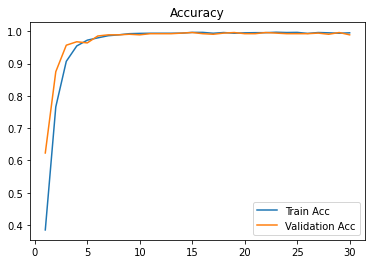

In [39]:
x_range = np.arange(1, EPOCHS+1, step=1)

plt.plot(x_range, results["customSpeechRecognition"]['acc']['train'], label='Train Acc')
plt.plot(x_range, results["customSpeechRecognition"]['acc']['val'], label='Validation Acc')
plt.title("Accuracy")
plt.legend(loc='best')
plt.show()

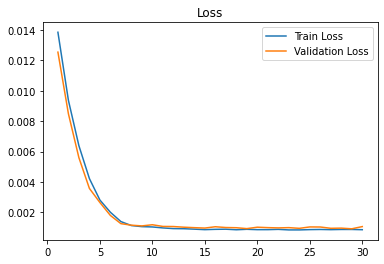

In [40]:
x_range = np.arange(1, EPOCHS+1, step=1)

plt.plot(x_range, results["customSpeechRecognition"]['loss']['train'], label='Train Loss')
plt.plot(x_range, results["customSpeechRecognition"]['loss']['val'], label='Validation Loss')
plt.title("Loss")
plt.legend(loc='best')
plt.show()